### Welcome to this kernel.In this kernel i am using some sort of attention/related techniques to focus on areas .Before you fork please support and upvote the current kernel and following reference kernels. <br>
1. https://www.kaggle.com/mathormad/aptos-resnet50-baseline <br>
2. https://www.kaggle.com/kmader/inceptionv3-for-retinopathy-gpu-hr#Attention-Model <br>



### And i used techiniques refered in [this](https://www.kaggle.com/aakashnain/what-does-a-cnn-see) kernel to visualize what my model is looking at.Beautifully scripted kernel with great explaination go through it for more clarity. <br>

### Thanks to the reference kernels authors <br>

* [KeepLearning](https://www.kaggle.com/mathormad) <br>
* [Kevin Mader](https://www.kaggle.com/kmader) <br>
* [Nain](https://www.kaggle.com/aakashnain)

## Installing efficientnet module

In [1]:
!pip install -U '../input/install/efficientnet-0.0.3-py2.py3-none-any.whl'

Processing /kaggle/input/install/efficientnet-0.0.3-py2.py3-none-any.whl


## Importing libraries and data

In [2]:
import numpy as np
import pandas as pd 
import os
print(os.listdir("../input"))
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
import matplotlib.pyplot as plt
from efficientnet import EfficientNetB3,EfficientNetB4,EfficientNetB5
import skimage.io
from skimage.transform import resize
import imgaug as aug
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from keras.applications.densenet import DenseNet121,DenseNet169,preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import imgaug as ia
import keras.callbacks as callbacks
from keras.callbacks import Callback
%config InlineBackend.figure_format="svg"
%matplotlib inline

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 256
NUM_CLASSES = 5

['efficientnet-keras-weights-b0b5', 'install', 'aptos2019-blindness-detection', 'densenet-keras']


Using TensorFlow backend.


### Setting the seed

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(444)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(444)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
aug.seed(444)

In [4]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

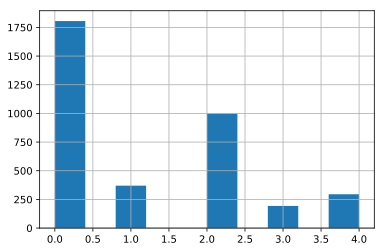

In [5]:
x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=8)
y.hist()

In [6]:
y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(3112,)
(3112, 5)
(550,)
(550, 5)


## Data Augmentation

In [7]:
#refernce: https://github.com/aleju/imgaug
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True)

In [8]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y


## Basemodel - EfficientnetB5

In [9]:
in_lay = Input(shape=(256,256,3))
base_model = EfficientNetB5(weights=None,
    input_shape=(SIZE,SIZE,3),
    include_top=False
                   )
base_model.load_weights("../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5")
pt_depth = base_model.get_output_shape_at(0)[-1]
pt_features = base_model(in_lay)
bn_features = BatchNormalization()(pt_features)

## Attention model

In [10]:
# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(5, activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

In [11]:
retina_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Model)         (None, 8, 8, 2048)   28513520    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_117 (BatchN (None, 8, 8, 2048)   8192        efficientnet-b5[1][0]            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 8, 8, 2048)   0           batch_normalization_117[0][0]    
__________________________________________________________________________________________________
conv2d_156

In [12]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 30; batch_size = 16
checkpoint = ModelCheckpoint('../working/model_.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)
csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=False, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

In [13]:
# reference link: https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow
def kappa_loss(y_true, y_pred, y_pow=2, eps=1e-12, N=5, bsize=32, name='kappa'):
    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom*0.5 / (denom + eps) + categorical_crossentropy(y_true, y_pred)*0.5

In [14]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('../working/model_bestqwk.h5')

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [15]:
# warm up model
for layer in retina_model.layers:
    layer.trainable = False

for i in range(-3,0):
    retina_model.layers[i].trainable = True

retina_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3))

retina_model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_y)) / float(128)),
    epochs=2,
    workers=WORKERS, use_multiprocessing=True,
    verbose=1,
    callbacks=[qwk])

Epoch 1/2
35/35 [==============================] - 88s 3s/step

 epoch: 1 - QWK_score: 0.000000 

saving checkpoint:  0.0
Epoch 2/2
35/35 [==============================] - 83s 2s/step

 epoch: 2 - QWK_score: 0.004319 

saving checkpoint:  0.004318752679579485


In [16]:
# train all layers
for layer in retina_model.layers:
    layer.trainable = True
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
retina_model.compile(loss='categorical_crossentropy',
            # loss=kappa_loss,
            optimizer=Adam(lr=1e-4))
retina_model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

Epoch 1/30
195/195 [==============================] - 368s 2s/step - loss: 0.8460 - val_loss: 0.5629

Epoch 00001: val_loss improved from inf to 0.56289, saving model to ../working/model_.h5
35/35 [==============================] - 47s 1s/step

 epoch: 1 - QWK_score: 0.799813 

saving checkpoint:  0.7998132746041907
Epoch 2/30
195/195 [==============================] - 322s 2s/step - loss: 0.7310 - val_loss: 0.5293

Epoch 00002: val_loss improved from 0.56289 to 0.52928, saving model to ../working/model_.h5
35/35 [==============================] - 45s 1s/step

 epoch: 2 - QWK_score: 0.820341 

saving checkpoint:  0.8203412366319848
Epoch 3/30
195/195 [==============================] - 318s 2s/step - loss: 0.6944 - val_loss: 0.5227

Epoch 00003: val_loss improved from 0.52928 to 0.52267, saving model to ../working/model_.h5
35/35 [==============================] - 45s 1s/step

 epoch: 3 - QWK_score: 0.834274 

saving checkpoint:  0.8342742754901113
Epoch 4/30
195/195 [==================

## Lets see what does our model is looking at!

#### Here, we will explore two methods that are very simple to use and can give some good insights about model predictions. These are:

* Visualizing the intermediate layers outputs
* Class Activation Mapping

In [17]:
outputs = [layer.output for layer in retina_model.layers[2:17]]

# Define a new model that generates the above output
vis_model = Model(retina_model.input, outputs)

# check if we have all the layers we require for visualization 
vis_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Model)         (None, 8, 8, 2048)   28513520    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_117 (BatchN (None, 8, 8, 2048)   8192        efficientnet-b5[1][0]            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 8, 8, 2048)   0           batch_normalization_117[0][0]    
__________________________________________________________________________________________________
conv2d_156

In [18]:
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
['batch_normalization_117', 'dropout_1', 'conv2d_156', 'conv2d_157', 'conv2d_158', 'conv2d_159', 'conv2d_160', 'multiply_40', 'global_average_pooling2d_1', 'global_average_pooling2d_2', 'RescaleGAP', 'dropout_2', 'dense_1', 'dropout_3', 'dense_2']


#### Lets see the heatmap generated over the last convolution layer output.

In [19]:
def get_CAM(processed_image, predicted_label):
    """
    This function is used to generate a heatmap for a sample image prediction.
    
    Args:
        processed_image: any sample image that has been pre-processed using the 
                       `preprocess_input()`method of a keras model
        predicted_label: label that has been predicted by the network for this image
    
    Returns:
        heatmap: heatmap generated over the last convolution layer output 
    """
    # we want the activations for the predicted label
    predicted_output = retina_model.output[:, predicted_label]
    
    # choose the last conv layer in your model
    last_conv_layer = retina_model.layers[-9]
    print(retina_model.layers[-9])
    
    # get the gradients wrt to the last conv layer
    grads = K.gradients(predicted_output, last_conv_layer.output)[0]
    
    # take mean gradient per feature map
    grads = K.mean(grads, axis=(0,1,2))
    
    # Define a function that generates the values for the output and gradients
    evaluation_function = K.function([retina_model.input], [grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = evaluation_function([processed_image])
    
    # iterate over each feature map in yout conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    for i in range(2048): # we have 2048 features in our last conv layer
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

In [20]:
def show_random_sample(idx):
    """
    This function is used to select a random sample from the validation dataframe.
    It generates prediction for the same. It also stores the heatmap and the intermediate
    layers activation maps.
    
    Arguments:
        idx: random index to select a sample from validation data
    
    Returns:
        activations: activation values for intermediate layers
    """
    # select the sample and read the corresponding image and label
    img_id = df_train.iloc[idx]['id_code']
    img_path = '../input/aptos2019-blindness-detection/train_images/'+str(img_id)+'.png'
    sample_image = cv2.imread(img_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = cv2.resize(sample_image, (256, 256))
    sample_label = df_train.iloc[idx]["diagnosis"]
    
    # pre-process the image
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    sample_image_processed = preprocess_input(sample_image_processed)
    
    # generate activation maps from the intermediate layers using the visualization model
    activations = vis_model.predict(sample_image_processed)
  
    
    # get the label predicted by our original model
    pred_label = np.argmax(retina_model.predict(sample_image_processed), axis=-1)[0]
    
    # choose any random activation map from the activation maps 
    sample_activation = activations[1][0,:,:,8]
    
    # normalize the sample activation map
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    # convert pixel values between 0-255
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)

    # get the heatmap for class activation map(CAM)
    heatmap = get_CAM(sample_image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_image = heatmap * 0.5 + sample_image
    super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

    f,ax = plt.subplots(2,2, figsize=(10,8))
    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.show()
    
    return activations

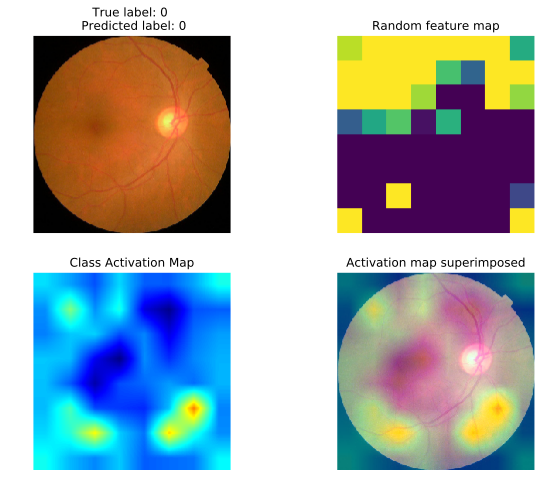

In [21]:
activations= show_random_sample(55)

#### Lets see the 5 convolution layers('conv2d_156','conv2d_157','conv2d_158','conv2d_159','conv2d_160') intermediate activation maps.

In [22]:
def visualize_intermediate_activations(layer_names, activations):
    """
    This function is used to visualize all the itermediate activation maps
    
    Arguments:
        layer_names: list of names of all the intermediate layers we chose
        activations: all the intermediate activation maps 
    """
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names[2:7], activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

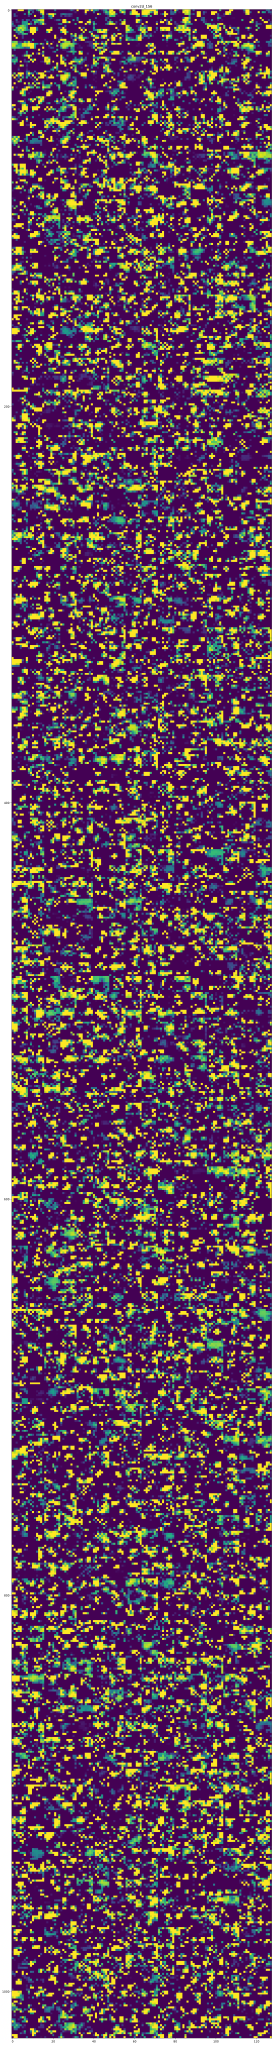

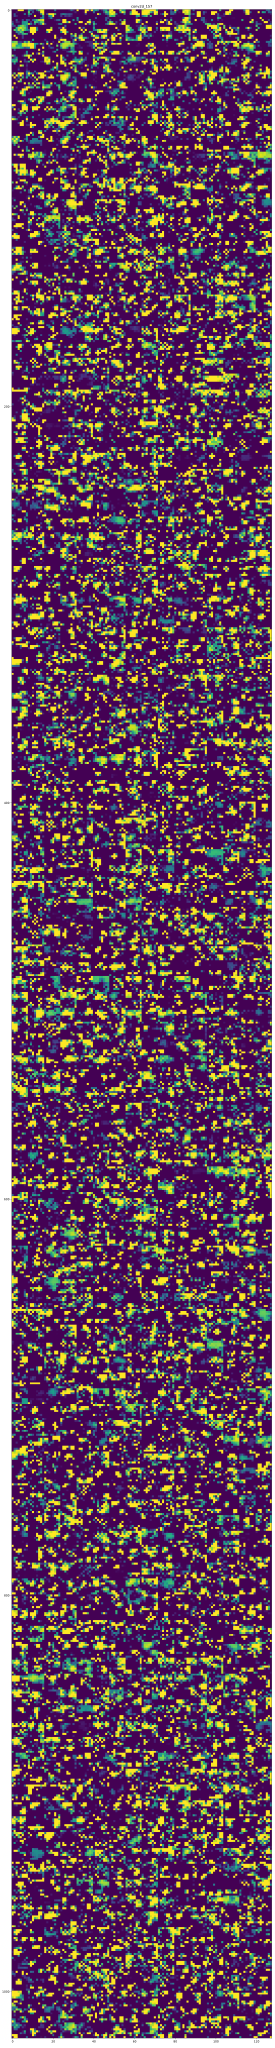

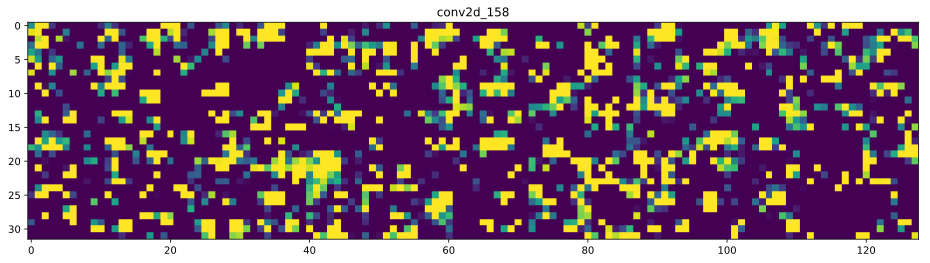

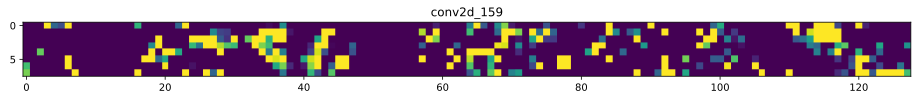

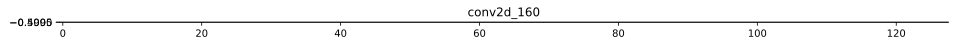

In [23]:
visualize_intermediate_activations(activations=activations, layer_names=layer_names)

#### Making predictions

In [24]:
submit = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
retina_model.load_weights('../working/model_bestqwk.h5')
predicted = []

In [25]:
for i, name in tqdm(enumerate(submit['id_code'])):
    path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
    image = cv2.imread(path)
    image = cv2.resize(image, (SIZE, SIZE))
    score_predict = retina_model.predict((image[np.newaxis])/255)
    label_predict = np.argmax(score_predict)
    predicted.append(str(label_predict))

1928it [01:56, 16.52it/s]


In [26]:
submit['diagnosis'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
